In [24]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
lm = LinearRegression()

import statsmodels.api as sm

#Load our two Data Frames
AmesDummies = pd.read_csv('AmesDummies.csv')
AmesDummiesOrdinal = pd.read_csv('AmesDummiesOrdinal.csv')

In [25]:
#Load the Forward Selection DF, which contains the list of Features to include in the linear model:
AmesFeatureDF = pd.read_csv('AmesDummiesForwardAICList.csv')

In [26]:
#Trim AmesDummiesOrdinal to a DF containing only the selected Features:
AmesDF = pd.concat([AmesDummiesOrdinal[list(AmesFeatureDF['CreatedFeatures'])],AmesDummiesOrdinal[['SalePrice']]], axis=1)
AmesDF.shape

(1458, 65)

In [27]:
#Transform AmesDF into the Train AmesDF
np.random.seed(19)
testIdxes = np.random.choice(range(1458), size=292, replace=False)
trainIdxes = list(set(range(1458))-set(testIdxes))

AmesDF2 = AmesDF.copy()
AmesDF = AmesDF.iloc[trainIdxes,]
AmesDFTest = AmesDF2.iloc[testIdxes,]

In [28]:
#As we can see, the trimmed DF has 120 total features removed, for a total of 67:
print(AmesDummiesOrdinal.shape)
print(AmesDF.shape)

AmesDF.index = range(1166)

(1458, 187)
(1166, 65)


In [29]:
#Initiate K-fold (n=5) cross-validation model to train/test:

import sklearn.model_selection as ms
ms_k5 = ms.KFold(n_splits=5, shuffle=True)

In [30]:
#Perform separate train/test validation runs for each of the 5 K-fold groups:

#Create X and Y variables
X = AmesDF.drop('SalePrice', axis=1)
Y = AmesDF['SalePrice']

#Rename the true (20% untouched) test DFs
testX = AmesDFTest.drop('SalePrice', axis=1)
testY = AmesDFTest['SalePrice']

#Instantiate the K-fold generator object:
np.random.seed(0)
AmesDF5Fold = ms_k5.split(AmesDF.drop('SalePrice', axis=1), AmesDF['SalePrice'])

#Produce list of test R^2 scores, and Actual vs Predicted lists for the individual runs
R2List = []
PredictList = []
ActualList = []
PureTestR2 = []
RMSLE = []
CoefsDFLinear = pd.DataFrame()

for train, test in AmesDF5Fold:
    
    #Run the fit using the train data for each K
    lm.fit(X.iloc[train,], Y[train])
    #Run your predicion for the "missing" K-part
    p = lm.predict(X.iloc[test,])
    #Check your schore for the missing K-part
    R2 = lm.score(X.iloc[test,], Y[test])
    #Run a test on the completely untouched test 20%
    TestR2 = lm.score(testX, testY)
    
    #Append these scores to the lists above
    R2List.append(R2)
    PureTestR2.append(TestR2)
    PredictList.append(p)
    ActualList.append(Y[test])
    
    #Make predictions for the completely untouched 20%
    PredictionsTest = lm.predict(testX)
    
    #Use these predictions to calculate RMSLE for the untouched 20% and append
    RMSLEvalue = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(PredictionsTest), 2)))
    RMSLE.append(RMSLEvalue)
    
    #Make a DF of predicted coefficients from each of the five runs
    CoefsDFLinear = pd.concat([CoefsDFLinear, pd.DataFrame({'Linear': pd.Series(lm.coef_)})], axis=1)
    
CoefsDFLinear.index = list(AmesFeatureDF['CreatedFeatures'])

In [31]:
CoefsDFLinear.head()

,Linear,Linear,Linear,Linear,Linear
OverallQual,6970.989613,7792.748621,7743.931189,7626.698144,6301.696270
TotalSF,73.975623,72.134227,76.115340,67.934250,63.555215
TotalBsmtSF,15.624215,17.923200,15.950181,16.455261,25.660617
KitchenQual,5187.058070,7301.748698,7506.134965,7367.294017,9668.768052
BsmtExposure,5039.953062,5712.330754,5580.240785,5825.499415,4531.844207


In [32]:
#Export the 5 K-fold-derived sets of linear coefficients to combine with our RF and XGBoost values:
CoefsDFLinear.to_csv('CoefsDFLinear.csv')

In [33]:
#What are the R^2 scores for each of our 5 runs?
print(R2List)
print(PureTestR2)
print(RMSLE)

[0.8735202617225851, 0.9107275079573801, 0.9232058685888915, 0.8561571142974096, 0.8705490295112279]
[0.8787357865593716, 0.8936914269868258, 0.8832268812323862, 0.8885436543503975, 0.8837751969301678]
[0.14722970591323187, 0.14571733983312118, 0.14744418232554285, 0.14290448346461834, 0.15217967175654923]


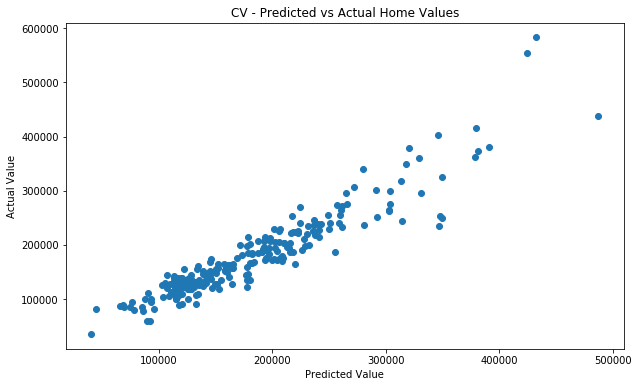

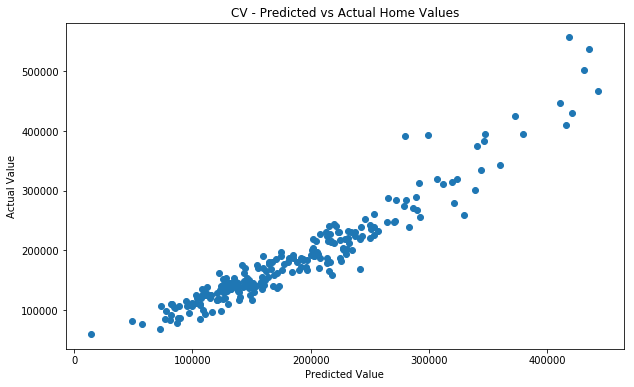

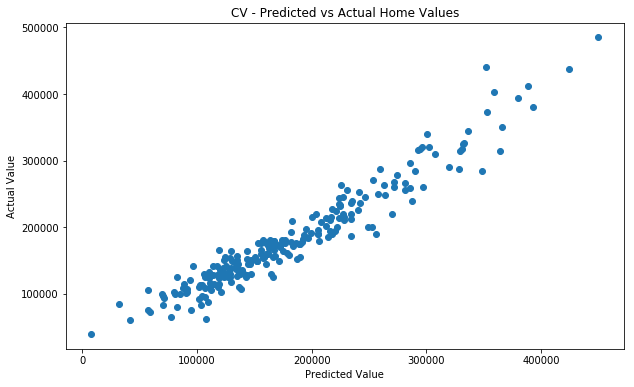

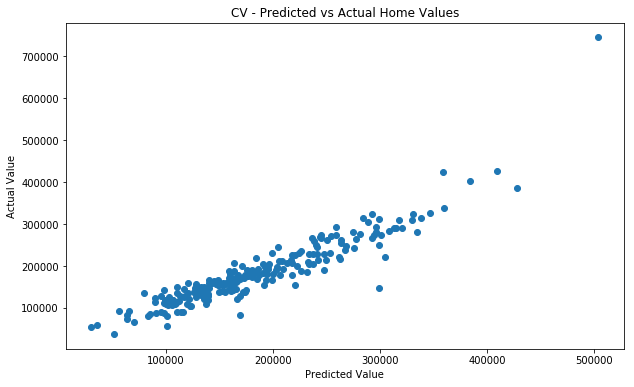

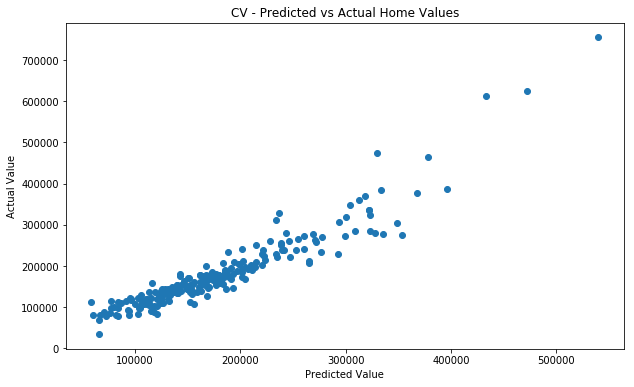

In [34]:
#Plot the predicted vs actual 'SalePrice' values for each of the 5 runs:
import matplotlib.pyplot as plt

for i in range(len(PredictList)):

    plt.figure(figsize=(10,6))
    plt.scatter(PredictList[i], ActualList[i])
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('CV - Predicted vs Actual Home Values')   
    plt.show()

In [35]:
#Just out of curiousity, what would this look like for only 2 folds (50/50 split between groups?)
ms_k2 = ms.KFold(n_splits=2, shuffle=True)

#Perform separate train/test validation runs for each of the 5 K-fold groups:

#Create X and Y variables
X = AmesDF.drop('SalePrice', axis=1)
Y = AmesDF['SalePrice']

testX = AmesDFTest.drop('SalePrice', axis=1)
testY = AmesDFTest['SalePrice']

#Instantiate the K-fold generator object:
np.random.seed(0)
AmesDF2Fold = ms_k2.split(AmesDF.drop('SalePrice', axis=1), AmesDF['SalePrice'])

#Produce list of test R^2 scores, and Actual vs Predicted lists for the individual runs
R2ListN2 = []
PredictListN2 = []
ActualListN2 = []
PureTestR2N2 = []

for train, test in AmesDF2Fold:
    lm.fit(X.iloc[train,], Y[train])
    p = lm.predict(X.iloc[test,])
    R2 = lm.score(X.iloc[test,], Y[test])
    TestR2 = lm.score(testX, testY)
    R2ListN2.append(R2)
    PureTestR2N2.append(TestR2)
    PredictListN2.append(p)
    ActualListN2.append(Y[test])

In [36]:
#What are the R^2 scores for each of our 2 runs? Still a fairly good 79% and 86% R^2 value.
print(R2ListN2)
print(PureTestR2N2)

[0.8388988349203057, 0.8698898073464352]
[0.8266668843748414, 0.8812023758303761]


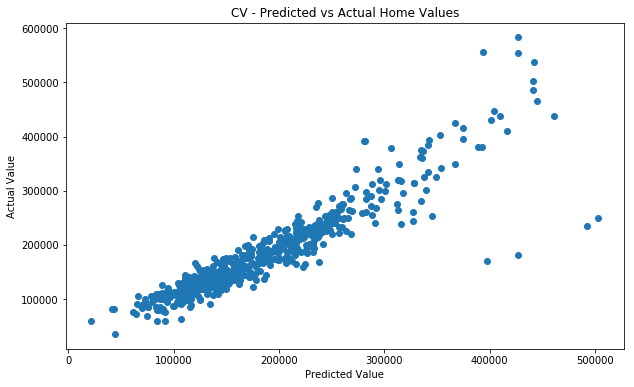

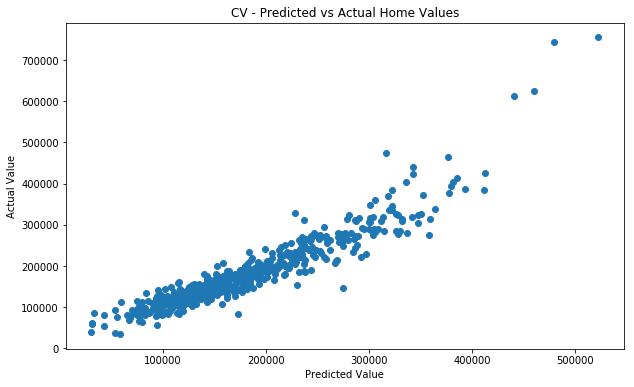

In [37]:
#Let's plot these:
for i in range(len(PredictListN2)):

    plt.figure(figsize=(10,6))
    plt.scatter(PredictListN2[i], ActualListN2[i])
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('CV - Predicted vs Actual Home Values')
    plt.show()